In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pybedtools
from amb import *
import seaborn  as sns
from amb import *
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import joblib

In [2]:
_type = 'Hypo'

In [3]:
all_bed= glob.glob(f'mC_FILTER_DMR_BED/*.Hypo-Hyper.aDMR.bed')
len(all_bed)

54

In [4]:
use_m3c_cts = joblib.load('/home/qzeng/project/aging/metadata/m3c_use_cts')
use_mc_cts = joblib.load('/home/qzeng/project/aging/metadata/mc_use_cts')
shared_cts = list(set(use_m3c_cts) & set(use_mc_cts)) 
shared_cts = [ct.replace(' ','_').replace('/','') for ct in shared_cts]

In [5]:
all_bed = [path for path in all_bed if path.split('/')[-1].split('.')[0] in shared_cts]

In [6]:
all_bed = sorted(all_bed)
len(all_bed)

36

In [7]:
path = 'mC_FILTER_DMR_BED/L5_NP_CTX_Glut.Hypo.aDMR.bed'

In [8]:
ct_name = pathlib.Path(path).name.split('.')[0]
tmpdf = pd.read_csv(path, sep = '\t', header = None)

tmpdf['9mo-8wk'] = tmpdf[5] - tmpdf[4]
tmpdf['18mo-9mo'] = tmpdf[6] - tmpdf[5]

cutoff = max(tmpdf['9mo-8wk'].max(), tmpdf['18mo-9mo'].max())
cutoff = round(cutoff, 1)
tmpdf['9mo-18mo'] = -tmpdf['18mo-9mo'] # for plot 


In [13]:
# fig, axes = plt.subplots(figsize=(6,3), nrows = 2, sharex=True,  
#                          constrained_layout = True,dpi = 250) #

# ax = axes[0]
# sns.barplot(data = tmpdf,
#             x = 'numeric_category',
#             y = '8wk-9mo',
#             color="#2179ee",
#             ax = ax)

# ax.set_ylim(0,cutoff)
# ax.set_xticks([])
# ax.set_xlabel('') 

# ax = axes[1]
# sns.barplot(x = tmpdf['numeric_category'],
#             y = tmpdf['18mo-9mo'],
#             color="#ff9f00",
#             ax = ax)

# ax.set_ylim(-cutoff,0)
# ax.set_xticks([])
# ax.set_xlabel('') 

# plt.title(f"{ct_name} aDMRs") 
# fig.savefig(f"{ct_name}.Dynamic.pdf", bbox_inches= 'tight')
# plt.show()   

## Hypo

In [33]:
#example_ct = 'L5_NP_CTX_Glut'
example_ct = 'Oligo_NN'

In [50]:
path = f'mC_FILTER_DMR_BED/{example_ct}.Hypo-Hyper.aDMR.bed'

In [46]:
ct_name = pathlib.Path(path).name.split('.')[0]
tmpdf = pd.read_csv(path, sep = '\t', header = None)
category_mapping = {category: index for index, category in enumerate(tmpdf[3].unique())}
tmpdf['numeric_category'] = tmpdf[3].map(category_mapping)

In [47]:
tmpdf['8wk-9mo'] = abs(tmpdf[4] - tmpdf[5])
tmpdf['9mo-18mo'] = abs(tmpdf[5] - tmpdf[6])

tmpdf['18mo-9mo'] = -tmpdf['9mo-18mo'] # for plot 

In [48]:
cutoff = 0.3

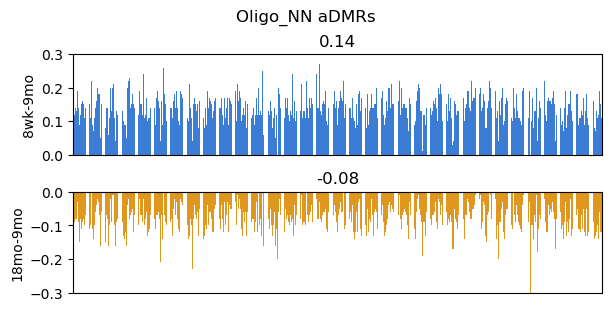

In [49]:
fig, axes = plt.subplots(figsize=(6,3), nrows = 2, sharex=True,  
                         constrained_layout = True,dpi = 100) #

ax = axes[0]
sns.barplot(data = tmpdf,
            x = 'numeric_category',
            y = '8wk-9mo',
            color="#2179ee",
            ax = ax)
# sns.lineplot(data=tmpdf, 
#              ax= ax, 
#              x="numeric_category",
#              color="#A9A9A9",
#              y="8wk-9mo")

ax.set_ylim(0,cutoff)
ax.set_xticks([])
ax.set_xlabel('')
_mean = round(tmpdf['8wk-9mo'].mean(),2)
ax.set_title(f'{_mean}') 


ax = axes[1]
sns.barplot(x = tmpdf['numeric_category'],
            y = tmpdf['18mo-9mo'],
            color="#ff9f00",
            ax = ax)
# sns.lineplot(data=tmpdf, 
#              ax= ax, 
#              x="numeric_category",
#              color="#A9A9A9",
#              y="18mo-9mo")

ax.set_ylim(-cutoff,0)
ax.set_xticks([])
ax.set_xlabel('') 
_mean = round(tmpdf['18mo-9mo'].mean(),2)
ax.set_title(f'{_mean}') 

fig.suptitle(f"{ct_name} aDMRs") 
#afig.savefig(f"{ct_name}.Dynamic.pdf", bbox_inches= 'tight')
plt.show()   

## plot all celltype

In [12]:
from scipy.stats import wilcoxon

In [13]:
stage_palette= {'Early Aging':'#2179ee', #blue
                'Late Aging':'#ff9f00'}

In [14]:
def get_plot_bed(path):
    tmpdf = pd.read_csv(path, sep = '\t', header = None)
    tmpdf['CellType'] = ct_name
    tmpdf['8wk-9mo'] = tmpdf[4] - tmpdf[5]
    tmpdf['9mo-18mo'] = tmpdf[5] - tmpdf[6]
    
    res = wilcoxon(tmpdf['8wk-9mo'], tmpdf['9mo-18mo'], alternative='greater')
    pvalue = res[1]
    
    to_plot = pd.concat([tmpdf['8wk-9mo'], tmpdf['9mo-18mo']])
    to_plot = pd.DataFrame(to_plot, columns= ["mCG Change"])
    early_aging_list = ['Early Aging'] * tmpdf['8wk-9mo'].shape[0]
    late_aging_list = ['Late Aging'] * tmpdf['9mo-18mo'].shape[0]

    to_plot['Aging Stage'] = early_aging_list + late_aging_list
    to_plot.index = pd.Series(range(0,to_plot.shape[0]))
    to_plot = to_plot.fillna(0)
    return to_plot, pvalue

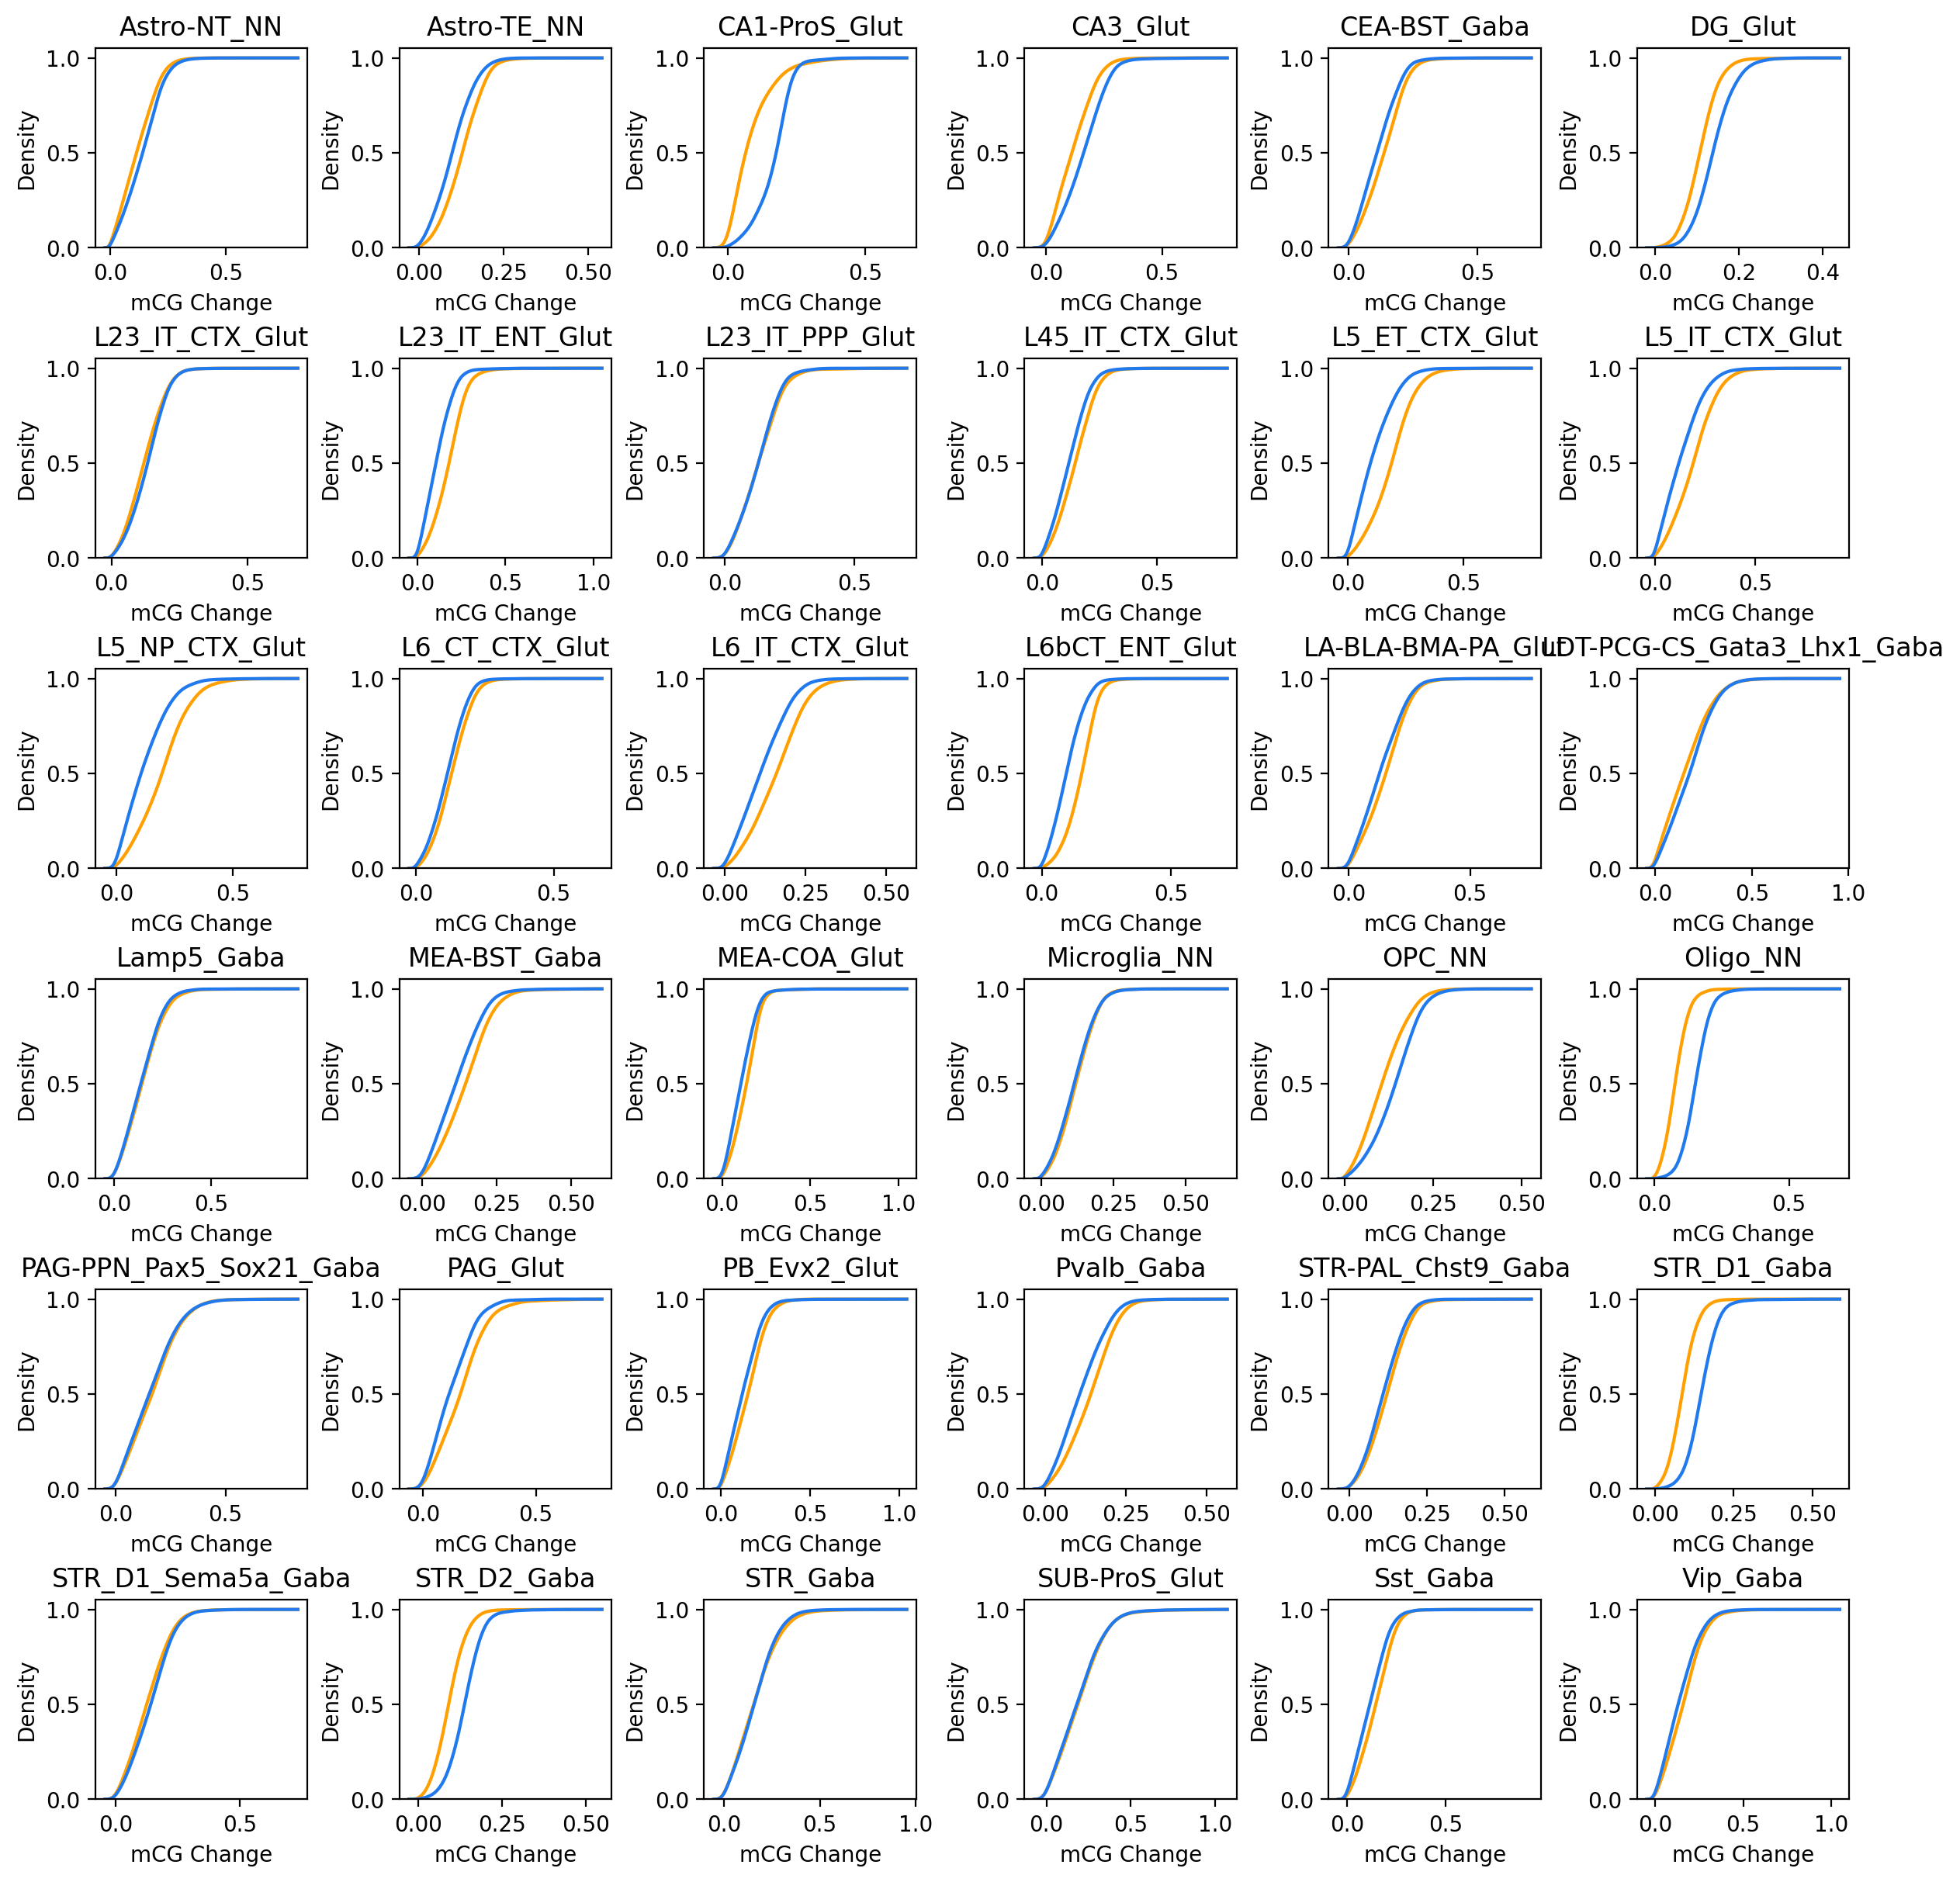

In [15]:
ncols = 6
nrows = 6
fig, axes = plt.subplots(figsize = (ncols*2,nrows*2), ncols = ncols, nrows = nrows,dpi = 200, constrained_layout = True)

for path, ax in zip(all_bed, axes.ravel()):
    to_plot_df , pvalue = get_plot_bed(path)
    to_plot_df['mCG Change'] = abs(to_plot_df['mCG Change'])
    ct = path.split('/')[-1].split('.')[0]
    
    sns.kdeplot(data=to_plot_df, 
                x="mCG Change", 
                hue="Aging Stage", 
                cumulative = True,
                common_norm=False,
                common_grid=True,
                ax = ax,
                palette = stage_palette, 
                legend=False)
    ax.set_title(f'{ct}')
fig.savefig(f"All.CellType.Dynamic.pdf", bbox_inches= 'tight')

In [26]:
# fig, ax = plt.subplots(figsize = (4,3), dpi = 200)
# sns.displot(to_plot_df , 
#             x = '8wk-9mo', 
#             hue = 'CellType',
#             ax = ax,
#             kind='kde')

In [26]:
# plt.figure(figsize=(5.5, 8), dpi = 200)
# cm = pch.ClusterMapPlotter(data=to_plot_df, top_annotation=col_ha,
#                        left_annotation=row_ha,
#                        row_cluster=False,col_cluster = False,
#                        row_split=row_annot.CellType,
#                        row_split_gap=0.5,
#                        label='mCG Frac. Change',rasterized=True,
#                        show_rownames=False,show_colnames=True,
#                        tree_kws={'row_cmap': 'Set1'},verbose=0,legend_gap=5,
#                        cmap='viridis',xticklabels_kws={'labelrotation':-90,'labelcolor':'black'})
# #plt.savefig(f"figure/{ct}.aDMR.heatmap.pdf", bbox_inches='tight')
# plt.show()